<a href="https://colab.research.google.com/github/albertnguyentran/Car-Image-Classifier/blob/main/Practice_ImageCNN_Pipeline_HappyOrSad_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Installing Dependencies

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
!pip install keras

In [ ]:
!pip list

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import imghdr
import numpy as np

1.0 Mount Google Drive

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


1.1 Limit GPU VRAM

In [ ]:
# Avoid OOM errors by setting GPU Memory (VRAM) Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

1.2 Remove dodgy images

In [ ]:
data_dir = "/content/gdrive/MyDrive/Code/ML/HappyorSad_CNN/Images"
os.listdir(os.path.join(data_dir, 'Happy'))

In [ ]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))
      

In [ ]:
#img = cv2.imread(os.path.join('/content/gdrive/MyDrive/Code/ML/CNN/Images', 'Happy', '05-12-21-happy-people.jpg'))
#img.shape
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.show()

(880, 1400, 3)

1.3 Load Data

In [ ]:
#tf.keras.utils.image_dataset_from_directory??
#Building data pipeline (default settings resize to 256x256)
data = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/Code/ML/CNN/Images')

Found 391 files belonging to 2 classes.


In [ ]:
#Looping through pipeline
data_iterator = data.as_numpy_iterator()

In [ ]:
#Accessing data from pipeline, two parts to each batch (image representation as a set of numpy arrays, labels - happy or sad)
batch = data_iterator.next()

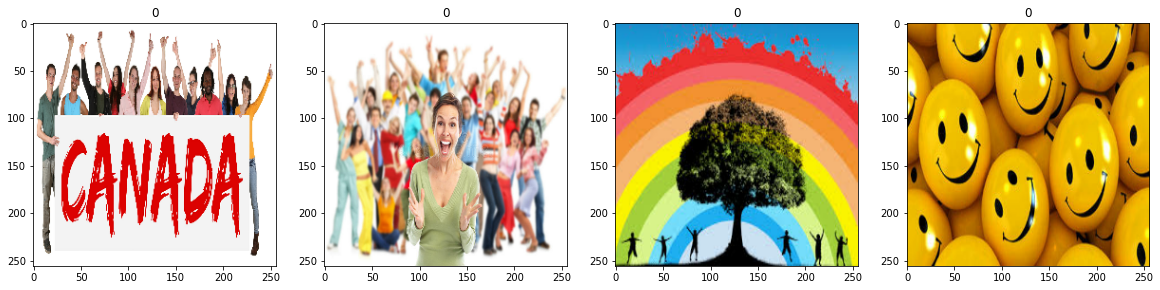

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# 2. Preprocess Data


2.1 Scale Data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

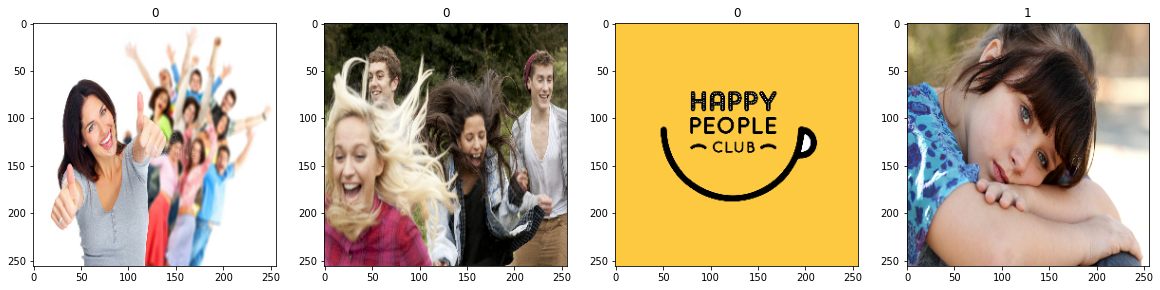

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
#Test max and min values after scaling: batch[0].min()

0.0

2.2 Split Data

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# 3. Building Model

3.1 Building Deep Learning Model

In [ ]:
model = Sequential()

In [ ]:
#Number of filters, size of filters, stride, activation
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#Condenses information
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

#Fully connected layers
model.add(Dense(256, activation='relu'))
#Single output (0 or 1)
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

3.2 Train

In [ ]:
logdir = '/content/gdrive/MyDrive/Code/ML/CNN/Logs'

In [ ]:
#Log out model training as it trains
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
#Data, how long you will train for, after all training batches are run validation data is used, additional callbacks
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 25s 2s/step - loss: 1.2806 - accuracy: 0.5104 - val_loss: 0.6744 - val_accuracy: 0.5469
Epoch 2/20
9/9 [==============================] - 22s 2s/step - loss: 0.6693 - accuracy: 0.5382 - val_loss: 0.6352 - val_accuracy: 0.4688
Epoch 3/20
9/9 [==============================] - 26s 3s/step - loss: 0.5940 - accuracy: 0.5625 - val_loss: 0.6057 - val_accuracy: 0.6875
Epoch 4/20
9/9 [==============================] - 34s 4s/step - loss: 0.5181 - accuracy: 0.8090 - val_loss: 0.5443 - val_accuracy: 0.6562
Epoch 5/20
9/9 [==============================] - 27s 3s/step - loss: 0.4945 - accuracy: 0.7465 - val_loss: 0.4434 - val_accuracy: 0.8594
Epoch 6/20
9/9 [==============================] - 23s 2s/step - loss: 0.3652 - accuracy: 0.8993 - val_loss: 0.3913 - val_accuracy: 0.8906
Epoch 7/20
9/9 [==============================] - 22s 2s/step - loss: 0.3083 - accuracy: 0.9028 - val_loss: 0.3628 - val_accuracy: 0.8281
Epoch 8/20
9/9 [==================

In [ ]:
hist.history

3.3 Plot Performance

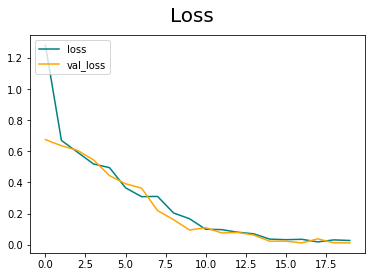

In [ ]:
#If loss drops and val_loss rises your model may be overfitting, apply some regularization or more data
#If loss isn't dropping, consider a more sosphicated neural network or more data, because it suggests your current model cannot effectively learn 
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

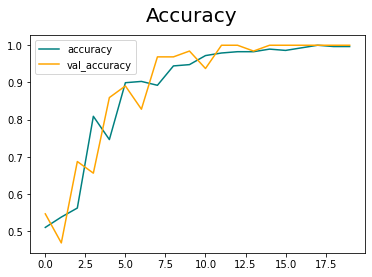

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4. Evaluate Performance

4.1 Evaluate

In [ ]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 1s 752ms/step


In [ ]:
#Higher precision, recall, accuracy is better (between 0-1)
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


4.2 Test

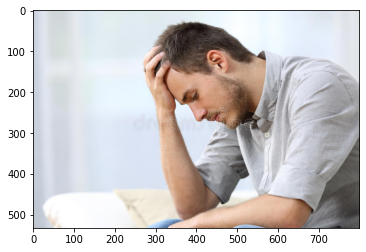

In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/Code/ML/CNN/sadperson.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

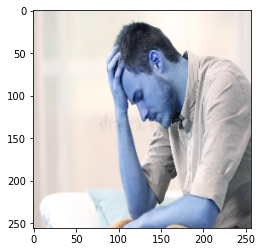

In [ ]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
np.expand_dims(resize, 0)

array([[[[219.      , 207.      , 201.      ],
         [220.1875  , 208.1875  , 202.1875  ],
         [221.9375  , 209.9375  , 203.9375  ],
         ...,
         [231.3125  , 227.3125  , 226.3125  ],
         [231.      , 227.      , 226.      ],
         [231.      , 227.      , 226.      ]],

        [[219.      , 207.      , 201.      ],
         [220.1875  , 208.1875  , 202.1875  ],
         [221.9375  , 209.9375  , 203.9375  ],
         ...,
         [231.3125  , 227.3125  , 226.3125  ],
         [231.      , 227.      , 226.      ],
         [231.      , 227.      , 226.      ]],

        [[219.      , 207.      , 201.      ],
         [220.1875  , 208.1875  , 202.1875  ],
         [221.9375  , 209.9375  , 203.9375  ],
         ...,
         [231.3125  , 227.3125  , 226.3125  ],
         [231.      , 227.      , 226.      ],
         [231.      , 227.      , 226.      ]],

        ...,

        [[206.41016 , 196.41016 , 189.41016 ],
         [206.41016 , 196.41016 , 189.41016 ]

In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 37ms/step


In [ ]:
yhat

array([[0.9987199]], dtype=float32)

In [ ]:
result = "Predicted class is Happy" if yhat < 0.5 else "Predicted class is Sad"
print(result)

Predicted class is Sad


# 5. Save the Model

5.1 Save the Model

In [ ]:
from keras.models import load_model

In [ ]:
model.save(os.path.join('/content/gdrive/MyDrive/Code/ML/Models', 'HappyOrSadModel.h5'))

In [ ]:
new_model = load_model(os.path.join('/content/gdrive/MyDrive/Code/ML/Models', 'HappyOrSadModel.h5'))

In [ ]:
new_yhat = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 54ms/step


In [ ]:
result = "Predicted class is Happy" if new_yhat < 0.5 else "Predicted class is Sad"
print(result)

Predicted class is Sad


Model is saved and works!